In [1]:
import zarr
import numpy as np
from pathlib import Path

def read_zarr_dataset(zarr_path, verbose=True):
    """
    ËØªÂèñZarrÊï∞ÊçÆÈõÜÂπ∂ÊâìÂç∞ÁªìÊûÑ‰ø°ÊÅØ
    
    ÂèÇÊï∞:
        zarr_path (str/Path): ZarrÊï∞ÊçÆÈõÜË∑ØÂæÑ
        verbose (bool): ÊòØÂê¶ÊâìÂç∞ËØ¶ÁªÜ‰ø°ÊÅØ
    
    ËøîÂõû:
        dict: ÂåÖÂê´ÊâÄÊúâÊï∞ÁªÑÂíåÁªÑÁöÑÂ≠óÂÖ∏
    """
    # ËΩ¨Êç¢‰∏∫PathÂØπË±°
    zarr_path = Path(zarr_path)
    
    if not zarr_path.exists():
        raise FileNotFoundError(f"ZarrË∑ØÂæÑ‰∏çÂ≠òÂú®: {zarr_path}")
    
    # ÊâìÂºÄZarrÊï∞ÊçÆÈõÜ
    try:
        # Ëá™Âä®Ê£ÄÊµãÂ≠òÂÇ®Á±ªÂûã (ÁõÆÂΩï/DirectoryStore Êàñ zip/ZipStore)
        if zarr_path.is_dir():
            store = zarr.DirectoryStore(zarr_path)
        elif zarr_path.suffix == '.zip':
            store = zarr.ZipStore(zarr_path, mode='r')
        else:
            raise ValueError("‰∏çÊîØÊåÅÁöÑZarrÂ≠òÂÇ®Ê†ºÂºèÔºåËØ∑‰ΩøÁî®ÁõÆÂΩïÊàñ.zipÊñá‰ª∂")
        
        root = zarr.open(store, mode='r')
        
        if verbose:
            print(f"ÊàêÂäüÂä†ËΩΩZarrÊï∞ÊçÆÈõÜ: {zarr_path}")
            print("\nÊï∞ÊçÆÈõÜÁªìÊûÑ:")
            _print_zarr_tree(root)
        
        # ËΩ¨Êç¢‰∏∫Â≠óÂÖ∏Ê†ºÂºèËøîÂõû
        data_dict = _zarr_to_dict(root)
        return data_dict
        
    except Exception as e:
        raise RuntimeError(f"ËØªÂèñZarrÊï∞ÊçÆÈõÜÂ§±Ë¥•: {str(e)}")
    finally:
        if 'store' in locals():
            store.close()

def _print_zarr_tree(group, indent=0):
    """ÈÄíÂΩíÊâìÂç∞ZarrÁªÑ/Êï∞ÁªÑÁªìÊûÑ"""
    prefix = '  ' * indent
    for key, item in group.items():
        if isinstance(item, zarr.core.Array):
            print(f"{prefix}‚îú‚îÄ {key} [Array] {item.shape} {item.dtype}")
        elif isinstance(item, zarr.hierarchy.Group):
            print(f"{prefix}‚îú‚îÄ {key} [Group]")
            _print_zarr_tree(item, indent + 1)

def _zarr_to_dict(node):
    """Â∞ÜZarrÁªÑËΩ¨Êç¢‰∏∫PythonÂ≠óÂÖ∏"""
    result = {}
    for key, item in node.items():
        if isinstance(item, zarr.core.Array):
            # Â∞ÜÊï∞ÁªÑÂä†ËΩΩÂà∞ÂÜÖÂ≠ò (Â∞èÊï∞ÊçÆÈõÜ) Êàñ‰øùÊåÅ‰∏∫zarrÊï∞ÁªÑ (Â§ßÊï∞ÊçÆÈõÜ)
            if item.nbytes < 100 * 1024 * 1024:  # Â∞è‰∫é100MBÁõ¥Êé•Âä†ËΩΩ
                result[key] = np.array(item)
            else:
                result[key] = item
        elif isinstance(item, zarr.hierarchy.Group):
            result[key] = _zarr_to_dict(item)
    return result

def process_done(data):
    # Ëé∑ÂèñepisodeÁªìÊùüÁ¥¢Âºï
    episode_ends = data['meta']['episode_ends'][:]
    
    # Â§ÑÁêÜdoneÂ≠óÊÆµ
    if 'done' not in data['data']:
        # ÂàõÂª∫ÂàùÂßãÂåñ‰∏∫0ÁöÑdoneÊï∞ÁªÑ
        total_steps = data['data']['action'].shape[0]
        done = np.zeros(total_steps, dtype=np.int32)
        
        # Ê†áËÆ∞episodeÁªàÊ≠¢‰ΩçÁΩÆ
        for end_idx in episode_ends:
            if end_idx <= total_steps:
                done[end_idx-1] = 1
            else:
                print(f"Warning: Episode end index {end_idx} exceeds dataset size {total_steps}")
        
        # Â∞ÜdoneÊï∞ÁªÑÂÜôÂÖ•Êï∞ÊçÆÈõÜÔºàÈúÄË¶ÅÂÜôÂÖ•ÊùÉÈôêÊó∂‰ΩøÁî®Ôºâ
        # Ê≥®ÊÑèÔºöÂ¶ÇÊûúÊï∞ÊçÆÈõÜÊòØÂè™ËØªÊ®°ÂºèÔºåËøôÈáåÂ∫îËØ•Âú®ÂÜÖÂ≠ò‰∏≠ÂàõÂª∫ÂâØÊú¨
        data['data']['done'] = done
        
    return data

def process_next_obs(data):
    episode_ends = data['meta']['episode_ends'][:]  # Ëé∑ÂèñÊâÄÊúâepisodeÁªìÊùü‰ΩçÁΩÆ
    head_cam = data['data']['head_camera']  # ÂéüÂßãÂ§¥ÊëÑÂÉèÂ§¥Êï∞ÊçÆ
    next_head_cam = np.zeros_like(head_cam)  # ÂàùÂßãÂåñnext_head_cam
    state = data['data']['state']
    next_state = np.zeros_like(state)
    
    start_idx = 0
    for end_idx in episode_ends:
        # Â§ÑÁêÜÂΩìÂâçepisodeÂÜÖÁöÑÊï∞ÊçÆ
        episode_slice = slice(start_idx, end_idx)
        
        # Â∏∏ËßÑÂπ≥ÁßªÔºöÂΩìÂâçepisodeÂÜÖÔºånext_head_cam[t] = head_cam[t+1]
        if end_idx - start_idx > 1:  # Á°Æ‰øùepisodeÈïøÂ∫¶>1
            next_head_cam[episode_slice][:-1] = head_cam[episode_slice][1:]
            next_state[episode_slice][:-1] = state[episode_slice][1:]
        
        # episodeÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥Ê≠•ÁöÑnext_head_camËÆæ‰∏∫0ÔºàÁªàÊ≠¢Áä∂ÊÄÅÔºâ
        next_head_cam[end_idx - 1] = 0  # -1Âõ†‰∏∫end_idxÊòØexclusiveÁöÑ
        next_state[end_idx - 1] = 0
        
        start_idx = end_idx  # ÁßªÂä®Âà∞‰∏ã‰∏Ä‰∏™episode
    
    # Â§ÑÁêÜÊúÄÂêé‰∏Ä‰∏™episode‰πãÂêéÁöÑÊï∞ÊçÆÔºàÂ¶ÇÊûúÊúâÔºâ
    if start_idx < len(head_cam):
        next_head_cam[start_idx:-1] = head_cam[start_idx+1:]
        next_head_cam[-1] = 0  # Êï¥‰∏™Êï∞ÊçÆÈõÜÁöÑÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥Ê≠•
        next_state[start_idx:-1] = state[start_idx+1:]
        next_state[-1] = 0  # Êï¥‰∏™Êï∞ÊçÆÈõÜÁöÑÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥Ê≠•
    
    data['data']['next_head_camera'] = next_head_cam
    data['data']['next_state'] = next_state
    return data

ÊàêÂäüÂä†ËΩΩZarrÊï∞ÊçÆÈõÜ: policy/Diffusion-Policy/data/put_apple_cabinet_bc_bcq_D435_40.zarr

Êï∞ÊçÆÈõÜÁªìÊûÑ:
‚îú‚îÄ data [Group]
  ‚îú‚îÄ action [Array] (12439, 14) float32
  ‚îú‚îÄ apple_pose [Array] (12439, 7) float32
  ‚îú‚îÄ cabinet_pose [Array] (12439, 7) float32
  ‚îú‚îÄ done [Array] (12439,) int32
  ‚îú‚îÄ head_camera [Array] (12439, 3, 240, 320) uint8
  ‚îú‚îÄ next_head_camera [Array] (12439, 3, 240, 320) uint8
  ‚îú‚îÄ next_state [Array] (12439, 14) float32
  ‚îú‚îÄ reward [Array] (12439,) float32
  ‚îú‚îÄ state [Array] (12439, 14) float32
  ‚îú‚îÄ tcp_action [Array] (12439, 14) float32
‚îú‚îÄ meta [Group]
  ‚îú‚îÄ episode_ends [Array] (40,) int64
action: [-1.2319934e+00  2.0180216e+00  4.3902537e-01  1.5789876e+00
 -1.2319863e+00  1.5707947e+00 -2.0000000e-02  6.6163695e-01
  2.3036411e+00  2.3045468e+00 -1.5716940e+00  1.0569643e-05
  6.6164887e-01  1.1250000e-04]
episode_ends: [  312   624   938  1244  1553  1869  2173  2484  2798  3104  3415  3731
  4050  4365  4666  49

/home/wzh-2004/miniconda3/envs/RoboTwin/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wzh-2004/miniconda3/envs/RoboTwin/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wzh-2004/miniconda3/envs/RoboTwin/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wzh-2004/miniconda3/envs/RoboTwin/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wzh-2004/miniconda3/envs/RoboTwin/lib/python3.8/site-packages/IPython/core/pylabtools.

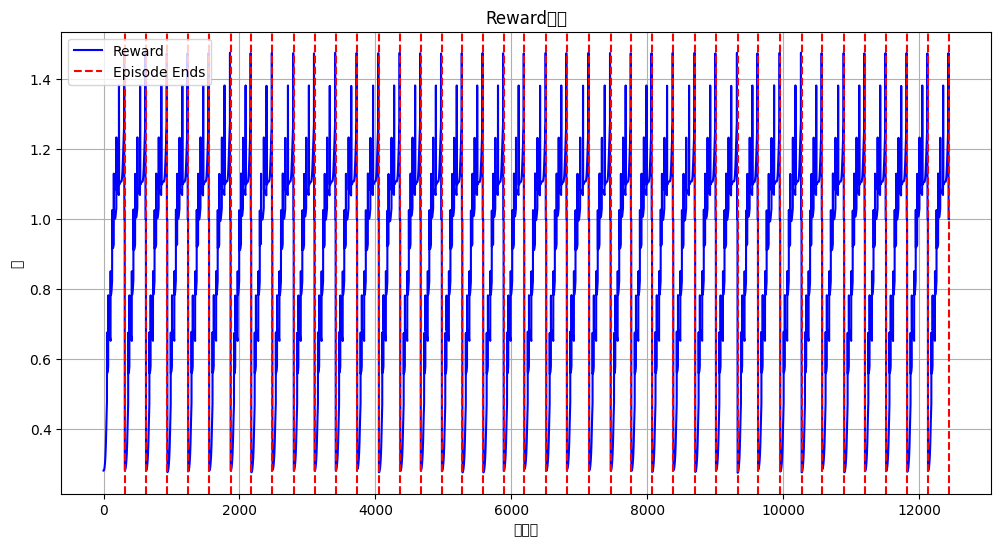

In [2]:
# Á§∫‰æã1: ËØªÂèñÁõÆÂΩïÂûãZarr
import matplotlib.pyplot as plt
dataset_path = 'policy/Diffusion-Policy/data/put_apple_cabinet_bc_bcq_D435_40.zarr'  # ÊõøÊç¢‰∏∫‰Ω†ÁöÑË∑ØÂæÑ

process_flag = False

if process_flag:
    data = zarr.open(dataset_path, mode='a')  # 'a'Ê®°ÂºèÂÖÅËÆ∏‰øÆÊîπ
    data = process_done(data)
    # data = process_done(data)
    data = process_next_obs(data)

# # ËØªÂèñÊï∞ÊçÆ
data = read_zarr_dataset(dataset_path)

print("action:", data['data']['action'][200,:])
# print("state:",data['data']['state'][10,:])
# print("tcp_action:",data['data']['tcp_action'][10,:])
# print("apple_pose:",data['data']['apple_pose'][100])
# print("cabinet_pose:",data['data']['cabinet_pose'][100])

# # Á§∫‰æã2: ËØªÂèñÂéãÁº©ÁöÑZarr
# # zip_data = read_zarr_dataset("./dataset.zip")


# # ÊèêÂèñrewardÂíåstateÊï∞ÊçÆ
reward_data = data['data']['reward']
# state_data = data['data']['state']
episode_ends = data['meta']['episode_ends']  # Ëé∑Âèñepisode_endsÊï∞ÊçÆ

print("episode_ends:",episode_ends)

m = 311
print("real_state:", data['data']['state'][m])
print("next_state:", data['data']['next_state'][m])

# print("real_head_camera:", data['data']['head_camera'][m])
# print("next_head_camera:", data['data']['next_head_camera'][m])

# print("doneÊ†áËÆ∞:", data['data']['done'][m])
# print("reward_{m}:",reward_data[m])


# ÂàõÂª∫ÂõæÂΩ¢
plt.figure(figsize=(12, 6))

# ÁªòÂà∂rewardÊï∞ÊçÆ
plt.plot(reward_data, label='Reward', color='blue')

# Âú®episode_endsÂ§ÑÁªòÂà∂Á´ñÁ∫ø
for episode_end in episode_ends:
    plt.axvline(x=episode_end, color='red', linestyle='--', label='Episode Ends' if episode_end == episode_ends[0] else "")

# Ê∑ªÂä†Âõæ‰æãÂíåÊ†áÈ¢ò
plt.title('RewardÊï∞ÊçÆ')
plt.xlabel('Êó∂Èó¥Ê≠•')
plt.ylabel('ÂÄº')
plt.legend()
plt.grid()

# ÊòæÁ§∫ÂõæÂΩ¢
plt.show()


In [12]:
import pickle

# ËØªÂèñpklÊï∞ÊçÆÈõÜÁöÑÂáΩÊï∞
def read_pkl_dataset(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

# Á§∫‰æãÔºöËØªÂèñpklÊï∞ÊçÆÈõÜ
pkl_file_path = 'data/put_apple_cabinet_D435_20_pkl/episode0/0.pkl'  # ÊõøÊç¢‰∏∫‰Ω†ÁöÑpklÊñá‰ª∂Ë∑ØÂæÑ
pkl_data = read_pkl_dataset(pkl_file_path)

# ÊâìÂç∞ÂÖ∂‰∏≠ÁöÑ‰∏Ä‰∏™Êï∞ÊçÆÁõÆÂΩï
print("Êï∞ÊçÆÁõÆÂΩïÁ§∫‰æã:", pkl_data.keys())
print(pkl_data['observation'].keys())


Êï∞ÊçÆÁõÆÂΩïÁ§∫‰æã: dict_keys(['observation', 'pointcloud', 'joint_action', 'endpose'])
dict_keys(['head_camera', 'left_camera', 'right_camera', 'front_camera'])


ÊàêÂäüÂä†ËΩΩZarrÊï∞ÊçÆÈõÜ: policy/Diffusion-Policy/data/put_apple_cabinet_bc_D435_20.zarr

Êï∞ÊçÆÈõÜÁªìÊûÑ:
‚îú‚îÄ data [Group]
  ‚îú‚îÄ action [Array] (6060, 14) float32
  ‚îú‚îÄ head_camera [Array] (6060, 3, 240, 320) uint8
  ‚îú‚îÄ right_camera [Array] (6060, 3, 240, 320) uint8
  ‚îú‚îÄ state [Array] (6060, 14) float32
  ‚îú‚îÄ tcp_action [Array] (6060, 14) float32
‚îú‚îÄ meta [Group]
  ‚îú‚îÄ episode_ends [Array] (20,) int64
Âä®‰ΩúÊï∞ÊçÆ‰∏≠ÁöÑÊúÄÂ§ßÂÄº: 2.3228462
TCPÂä®‰ΩúÊï∞ÊçÆ‰∏≠ÁöÑÊúÄÂ§ßÂÄº: 3.141573
[ 303  606  909 1212 1515 1818 2121 2424 2727 3030 3333 3636 3939 4242
 4545 4848 5151 5454 5757 6060]
action: [-0.14526245  0.09501953  0.01627016  0.07875045 -0.14526175  0.06422811
  0.045       0.05832812  0.09895018  0.03372615  0.00664589  0.05831462
  0.00085645  0.045     ]
state: [-0.14526245  0.09501953  0.01627016  0.07875045 -0.14526175  0.06422811
  0.045       0.05832812  0.09895018  0.03372615  0.00664589  0.05831462
  0.00085645  0.045     ]
tcp_action: [-2.8726384e-

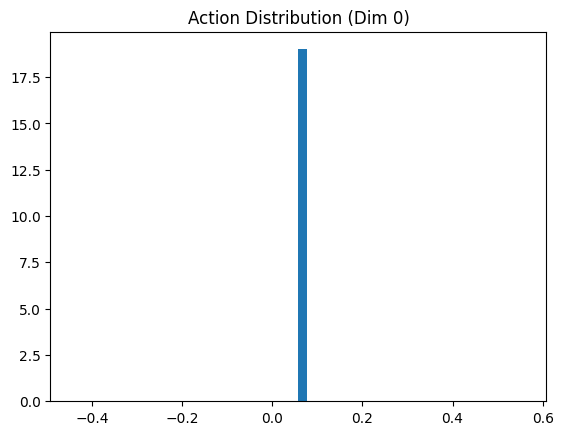

In [11]:
# dataset_path = 'policy/Diffusion-Policy/data/put_apple_cabinet_rl_D435_50.zarr'  # ÊõøÊç¢‰∏∫‰Ω†ÁöÑË∑ØÂæÑ
dataset_path = 'policy/Diffusion-Policy/data/put_apple_cabinet_bc_D435_20.zarr'  # ÊõøÊç¢‰∏∫‰Ω†ÁöÑË∑ØÂæÑ

data = read_zarr_dataset(dataset_path)
# rewards = data['data']['reward']
# print("Reward mean:", rewards.mean(), "std:", rewards.std())

import matplotlib.pyplot as plt
import numpy as np
actions = data['data']['action']
tcp_actions = data['data']['tcp_action']
max_action = actions.max()
max_tcp_actions = tcp_actions.max()
print("Âä®‰ΩúÊï∞ÊçÆ‰∏≠ÁöÑÊúÄÂ§ßÂÄº:", max_action)
print("TCPÂä®‰ΩúÊï∞ÊçÆ‰∏≠ÁöÑÊúÄÂ§ßÂÄº:", max_tcp_actions)

episode_ends = data['meta']['episode_ends']
print(episode_ends)
action_list = []
for it in episode_ends:
    m = it + 10
    if it==episode_ends[-1]:
        break
    action_list.append(actions[m,:])
    print('action:',data['data']['action'][m])
    print('state:',data['data']['state'][m])
    print('tcp_action:',data['data']['tcp_action'][m])
# Â∞Üaction_listËΩ¨Êç¢‰∏∫numpyÊï∞ÁªÑÂêéÂÜçÂàáÁâá
action_array = np.array(action_list)
plt.hist(action_array[:,11], bins=50)
plt.title("Action Distribution (Dim 0)")
plt.show()


In [3]:
import torch
import argparse

def print_recursive(obj, indent=0, max_depth=3, max_items=20):
    prefix = " " * indent
    if isinstance(obj, dict):
        print(f"{prefix}Dict with {len(obj)} keys:")
        for i, (k, v) in enumerate(obj.items()):
            if i >= max_items:
                print(f"{prefix}  ... (and more)")
                break
            print(f"{prefix}  [{k}] -> ", end="")
            print_recursive(v, indent + 4, max_depth - 1)
    elif isinstance(obj, (list, tuple)):
        print(f"{prefix}{type(obj).__name__} of length {len(obj)}:")
        for i, item in enumerate(obj):
            if i >= max_items:
                print(f"{prefix}  ... (and more)")
                break
            print(f"{prefix}  [{i}] -> ", end="")
            print_recursive(item, indent + 4, max_depth - 1)
    elif isinstance(obj, torch.Tensor):
        print(f"{prefix}Tensor of shape {obj.shape}, dtype={obj.dtype}")
    else:
        print(f"{prefix}{type(obj).__name__}: {obj}")

def inspect_checkpoint(path):
    print(f"\nüîç Loading checkpoint from: {path}\n")
    ckpt = torch.load(path, map_location='cpu')

    print("=== üß± Checkpoint Structure ===")
    print_recursive(ckpt, indent=2, max_depth=3)

ckpt_path = "/home/wzh-2004/RoboTwin/policy/Diffusion-Policy/checkpoints/put_apple_cabinet_bc_D435_90_bc_0/20.ckpt"

inspect_checkpoint(ckpt_path)



üîç Loading checkpoint from: /home/wzh-2004/RoboTwin/policy/Diffusion-Policy/checkpoints/put_apple_cabinet_bc_D435_90_bc_0/20.ckpt

=== üß± Checkpoint Structure ===
  Dict with 3 keys:
    [cfg] ->       DictConfig: {'name': 'bc_robot_put_apple_cabinet_bc', '_target_': 'diffusion_policy.workspace.robotworkspace.BCRobotWorkspace', 'task_name': 'bc_put_apple_cabinet_bc', 'shape_meta': {'obs': {'head_cam': {'shape': [3, 240, 320], 'type': 'rgb'}, 'agent_pos': {'shape': [14], 'type': 'low_dim'}}, 'action': {'shape': [14]}}, 'exp_name': 'put_apple_cabinet_bc-robot_dp-train', 'horizon': 8, 'n_obs_steps': 3, 'n_action_steps': 8, 'n_latency_steps': 0, 'dataset_obs_steps': 3, 'past_action_visible': False, 'keypoint_visible_rate': 1.0, 'obs_as_global_cond': True, 'policy': {'_target_': 'diffusion_policy.policy.bc_policy.BehaviorCloningPolicy', 'shape_meta': {'obs': {'head_cam': {'shape': [3, 240, 320], 'type': 'rgb'}, 'agent_pos': {'shape': [14], 'type': 'low_dim'}}, 'action': {'shape': [14]}

/tmp/ipykernel_361710/3071495866.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location='cpu')
